# Taux-SSH_feedback: 

coupling between Taux anomalies in the western equatorial Pacific and SSH anomalies in the eastern equatorial Pacific. Computes sea surface height anomalies (SSHA; used as a proxy for subsurface temperature) in the eastern equatorial Pacific (horizontal Niño3 average) regressed onto zonal wind stress anomalies (TauxA) in the western equatorial Pacific (horizontal Niño4 average).

#### Reference observations:
TropFlux and AVISO 1993-2018 (main)

SSH: JPL-MEASURES 1993-2021, CSIRO-SSH 1993-2019, GODAS 1980-2023, ORAS5 1958-2022, SODA3.4.2 1979-2018
Taux: ERA5 1940-2022, 20CRv3 1836-2015, NCEP2 1979-2023


In [1]:
from esmvalcore.dataset import Dataset

from esmvalcore.config import CFG
CFG['rootpath']['OBS6'].append(r'/g/data/kj13/datasets/esmvaltool/obsdata-v2') #NCEP-DOE-R2 tos

In [2]:
model_ssh_datasets = { 
"ACCESS-ESM1-5": 
    Dataset(
    short_name='zos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    # timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

#tauu
model_tauu = {"ACCESS-ESM1-5": 
    model_ssh_datasets["ACCESS-ESM1-5"].copy(short_name='tauu',mip="Amon")}
model_tauu["ACCESS-ESM1-5"].add_supplementary(short_name='areacella', mip='fx')

model_ssh_datasets["ACCESS-ESM1-5"].add_supplementary(short_name='areacello', mip='Ofx')

## obs zos required
obs_tos_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    timerange="19790101/20190101",
    tier=2),
"ERA-Interim":
    Dataset(
    short_name='ts',
    dataset='ERA-Interim',
    mip="Amon",
    project='OBS6',
    type='reanaly',
    tier=3)
}
obs_tauu_datasets = {
 "ERA-Interim": 
     Dataset(
     short_name='tauu',
     dataset='ERA-Interim',
     mip="Amon",
     project='OBS6',
     type='reanaly',
     timerange="19790101/20190101",
     tier=3)
}

In [3]:
model_ssh_datasets = {name: dataset.load() for name, dataset in model_ssh_datasets.items()}
model_tauu = {name: dataset.load() for name, dataset in model_tauu.items()}

obs_tos_datasets = {name: dataset.load() for name, dataset in obs_tos_datasets.items()}
obs_tauu_datasets = {name: dataset.load() for name, dataset in obs_tauu_datasets.items()}

 tauu: attribute positive not present
loaded from file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Amon/tauu/gn/v20191115/tauu_Amon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc
 tauu: attribute positive not present
loaded from file 
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/scipy/linalg/_basic.py:1326: RuntimeWarning: overflow encountered in square
  resids = np.sum(np.abs(x[n:])**2, axis=0)
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [4]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import seasonal_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_season
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import mask_landsea
from esmvalcore.preprocessor import extract_time
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import scipy.stats

In [19]:
def ssh_east(cube):
    nino3_region = {"start_longitude": 210., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    # cube = extract_time(cube, start_year=1979, end_year=2000, start_month=1, end_month=12, start_day=1, end_day=31)
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="cm")
    cube = mask_landsea(cube, mask_out="land") #irregular
    cube = anomalies(cube, period="full")
    cube = detrend(cube, dimension="time", method="linear")
    cube = extract_region(cube, **nino3_region)
    cube = area_statistics(cube,operator='mean')
    
    return cube


def taux_west(cube):
    region = {"start_longitude": 160., "end_longitude": 210., "start_latitude": -5., "end_latitude": 5.}
    # cube = extract_time(cube, start_year=1979, end_year=2000, start_month=1, end_month=12, start_day=1, end_day=31)
    # cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="1e-3 N/m2")
    cube = mask_landsea(cube, mask_out="land") 
    cube = anomalies(cube, period="full")
    cube = detrend(cube, dimension="time", method="linear") # Create NaN for some reasons
    cube = extract_region(cube, **region)
    cube = area_statistics(cube,operator='mean')
    return cube   

In [20]:
model_ssh_prep = {name: ssh_east(dataset) for name, dataset in model_ssh_datasets.items()}
model_tauu_prep = {name: taux_west(dataset) for name, dataset in model_tauu.items()}

obs_tos_prep = {name: sst_east(dataset) for name, dataset in obs_tos_datasets.items()}
obs_tauu_prep = {name: taux_west(dataset) for name, dataset in obs_tauu_datasets.items()}

In [24]:
# scp.LinReg(model_tauu_prep["ACCESS-ESM1-5"].data, model_tos_prep["ACCESS-ESM1-5"].data).intcpt
B_data = model_tauu_prep["ACCESS-ESM1-5"].data
B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, model_ssh_prep["ACCESS-ESM1-5"].data, rcond=None)
coefs

array([2.6121965e-01, 1.3562453e-06], dtype=float32)

# Diagnostic Level 1

0.2612196393631045
(1980,) (1980,)
1e-3 N/m2 cm


Text(0.05, 0.95, 'model slope: 0.26')

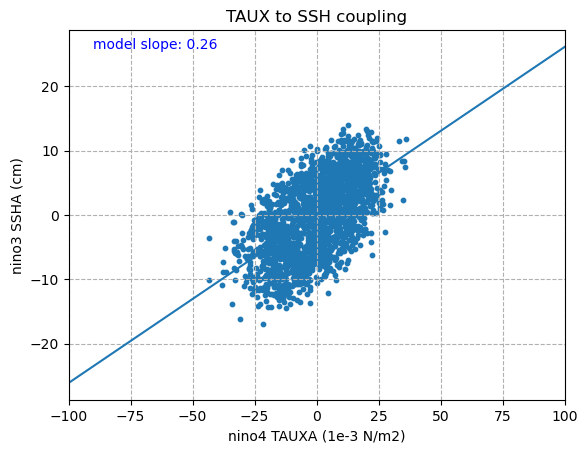

In [27]:
from scipy.stats import linregress
xseq = np.linspace(-100, 100, num=100)

slope, intcpt, _,_,_ = linregress(model_tauu_prep["ACCESS-ESM1-5"].data, model_ssh_prep["ACCESS-ESM1-5"].data)
plt.plot(xseq, intcpt+slope*xseq)
mod_slope = slope
print(slope)

# slope, intcpt, _,_,_ = linregress(obs_tos_prep["HadISST"].data, obs_tauu_prep["ERA-Interim"].data)
# plt.plot(xseq, intcpt+slope*xseq, color='black')
# metric_val = abs((mod_slope-slope)/slope)*100

print(model_tauu_prep["ACCESS-ESM1-5"].shape, model_ssh_prep["ACCESS-ESM1-5"].shape) #scatter plot
print(model_tauu_prep["ACCESS-ESM1-5"].units, model_ssh_prep["ACCESS-ESM1-5"].units) #ssh cm
plt.scatter(model_tauu_prep["ACCESS-ESM1-5"].data, model_ssh_prep["ACCESS-ESM1-5"].data, s=10)
yunit = model_ssh_prep["ACCESS-ESM1-5"].units 
xunit = model_tauu_prep["ACCESS-ESM1-5"].units

# print(obs_tos_prep["HadISST"].shape, obs_tauu_prep["ERA-Interim"].shape)
# plt.scatter(obs_tos_prep["HadISST"].data, obs_tauu_prep["ERA-Interim"].data,s=20, c='black', marker='D')
plt.xlim(-100,100)

plt.title('TAUX to SSH coupling')
plt.ylabel(f'nino3 SSHA ({yunit})')
plt.xlabel(f'nino4 TAUXA ({xunit})')
plt.grid(linestyle='--')
## text slope
plt.text(0.05,0.95, f'model slope: {mod_slope:.2f}', color='blue',transform=plt.gca().transAxes)

# print(metric_val)

# Diagnostic Level 2

(1980, 2)
slope (x<0) = 0.18604478000823527
slope (x>0) = 0.23185979836018664
0.2612196393631045


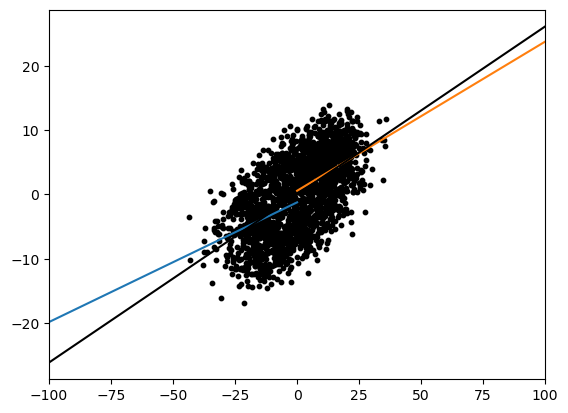

In [31]:
# SPLIT BY X<0 AND X>0 
import pandas as pd


df = pd.DataFrame({'tauu':model_tauu_prep["ACCESS-ESM1-5"].data, 'ssh':model_ssh_prep["ACCESS-ESM1-5"].data})
print(df.shape)

xseq = np.linspace(-100, 0, num=50)
slope, intcpt, _,_,_ = linregress(df.loc[df['tauu']<0, 'tauu'], df.loc[df['tauu']<0, 'ssh'])
plt.plot(xseq, intcpt+slope*xseq)
print(f'slope (x<0) = {slope}')
xseq = np.linspace(0, 100, num=50)
slope, intcpt, _,_,_ = linregress(df.loc[df['tauu']>0, 'tauu'], df.loc[df['tauu']>0, 'ssh'])
plt.plot(xseq, intcpt+slope*xseq)
print(f'slope (x>0) = {slope}')

plt.scatter(model_tauu_prep["ACCESS-ESM1-5"].data, model_ssh_prep["ACCESS-ESM1-5"].data, c='k',s=10)
xseq = np.linspace(-100, 100, num=50)
slope, intcpt, _,_,_ = linregress(df['tauu'], df['ssh'])
plt.plot(xseq, intcpt+slope*xseq, c='black')
plt.xlim(-100,100)
print(slope)

In [22]:
#level 3 zonal runningaverage
from esmvalcore.preprocessor import meridional_statistics

def sst_east_3(cube):
    nino3_region = {"start_longitude": 210., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    # cube = extract_time(cube, start_year=1979, end_year=2000, start_month=1, end_month=12, start_day=1, end_day=31)
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land") #irregular
    cube = anomalies(cube, period="full")
    cube = detrend(cube, dimension="time", method="linear")
    cube = extract_region(cube, **nino3_region)
    cube = area_statistics(cube,operator='mean')    
    return cube

def taux_eqp(cube):
    region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    # cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="1e-3 N/m2")
    cube = mask_landsea(cube, mask_out="land") 
    cube = anomalies(cube, period="full")
    cube = detrend(cube, dimension="time", method="linear") # Create NaN for some reasons
    cube = extract_region(cube, **region)
    cube = meridional_statistics(cube,operator='mean')
    cube = rolling_window_statistics(cube, coordinate='longitude',operator='mean',window_length=30)
    return cube 
#lin_regress

In [23]:
model_tos_prep = {name: sst_east_3(dataset) for name, dataset in model_ts_datasets.items()}
model_tauu_prep = {name: taux_eqp(dataset) for name, dataset in model_tauu.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'longitude' were ignored in the rolling window operation.
  warnings.warn(


In [32]:
# reg2_mod = lin_regress_matrix(model_tos_prep["ACCESS-ESM1-5"], model_tauu_prep["ACCESS-ESM1-5"])
print(model_tos_prep["ACCESS-ESM1-5"].shape, model_tauu_prep["ACCESS-ESM1-5"].shape)

B_data = model_tos_prep["ACCESS-ESM1-5"].data
B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, model_tauu_prep["ACCESS-ESM1-5"].data, rcond=None)
coefs#.shape #add long coordinate


(432,) (432, 35)


masked_array(
  data=[[ 1.1355944e+00,  1.3697059e+00,  1.6181743e+00,  1.9058282e+00,
          2.1999342e+00,  2.4992337e+00,  2.8069642e+00,  3.1235673e+00,
          3.4482038e+00,  3.7774162e+00,  4.1039696e+00,  4.4244814e+00,
          4.7381449e+00,  5.0395875e+00,  5.3221226e+00,  5.5775585e+00,
          5.8002868e+00,  5.9899511e+00,  6.1442714e+00,  6.2609143e+00,
          6.3393521e+00,  6.3798604e+00,  6.3847060e+00,  6.3560619e+00,
          6.2926216e+00,  6.1939764e+00,  6.0612626e+00,  5.8966842e+00,
          5.7037625e+00,  5.4852386e+00,  5.2423887e+00,  4.9781523e+00,
          4.6965656e+00,  4.4006057e+00,  4.0916419e+00],
        [-1.6641430e-07, -9.5820624e-08, -9.4792341e-08, -1.1595748e-07,
         -1.3732252e-07, -9.9194267e-08, -1.2723063e-07, -4.1205251e-08,
         -5.3271641e-08, -4.5840039e-08, -8.1392599e-08, -7.4094913e-08,
         -4.1034717e-08,  4.1037800e-09, -6.5015357e-08, -3.3843314e-08,
         -2.6300393e-08, -5.3409575e-08, -6.2772926e

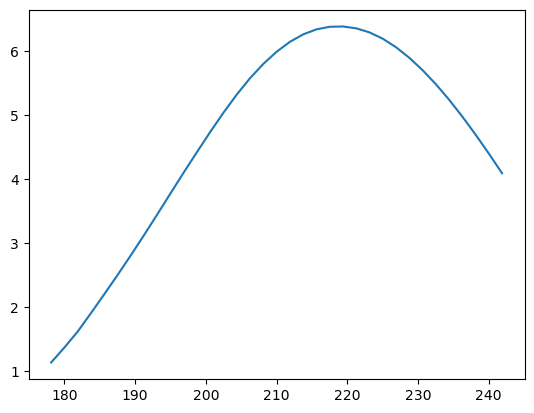

In [37]:
from scipy.stats import linregress
def lin_regress(cube_ssta, cube_nino34): #1d pattern
    slope_ls = []
    for lon_slice in cube_ssta.slices(['time']): 
        res = linregress(cube_nino34.data, lon_slice.data)
        slope_ls.append(res[0])

    return cube_ssta.coord('longitude').points, slope_ls

reg_mod = lin_regress( model_tauu_prep["ACCESS-ESM1-5"], model_tos_prep["ACCESS-ESM1-5"])
plt.plot(*reg_mod)